# VinBigData Chest X-ray Abnormalities Classifier

# Table of Contents

1. Introduction
2. Objectives
3. Data
4. Dataset Preparation
5. Installation
6. Exploratory Data Analysis
7. Methods
8. Image Visualizaion and Augmentation with Albumentations
9. Model Building
10. Model Training
11. Model Testing and Validation
12. Results
13. Discussion
14. Furture Improvement
15. References
16. Appendices

**1. Introduction**

When you have a broken arm, radiologists help save the day—and the bone. These doctors diagnose and treat medical conditions using imaging techniques like CT and PET scans, MRIs, and, of course, X-rays. Yet, as it happens when working with such a wide variety of medical tools, radiologists face many daily challenges, perhaps the most difficult being the chest radiograph. **The interpretation of chest X-rays can lead to medical misdiagnosis**, even for the best practicing doctor. Computer-aided detection and diagnosis systems (CADe/CADx) would help reduce the pressure on doctors at metropolitan hospitals and improve diagnostic quality in rural areas.

The annotations were collected via VinBigData's web-based platform, VinLab. Details on building the dataset can be found in the organizer's recent paper “VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.und in the organizer's recent paper “VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.

**2. Objective**

Existing methods of interpreting chest X-ray images classify them into a list of findings. There is currently no specification of their locations on the image which sometimes leads to inexplicable results. A solution for localizing findings on chest X-ray images is needed for providing doctors with more meaningful diagnostic assistance

In this competition, we are classifying common thoracic lung diseases and localizing critical findings. This is an **object detection and classification** problem from chest x-ray image (radiographs)

**3. Data**
**3.1 Intro**

In this competition:

* Task: Automatically localize and classify **14 types of thoracic abnormalities** from chest radiographs.
* Dataset: Consisting of **18,000 scans: 15,000 train images** and will be evaluated on a test set of **3,000 images**.

For each test image, you will be predicting a bounding box and class for all findings. If you predict that there are no findings, you should create a prediction of "14 1 0 0 1 1" (14 is the class ID for no finding, and this provides a one-pixel bounding box with a confidence of 1.0).

The images are in DICOM format, which means they contain additional data that might be useful for visualizing and classifying

**3.2 Dataset information**

The dataset comprises 18,000 postero-anterior (PA) CXR scans in DICOM format, which were de-identified to protect patient privacy. All images were labeled by a panel of experienced radiologists for the presence of 14 critical radiographic findings as listed below:



The "No finding" observation (14) was intended to capture the absence of all findings above.

**4. Data Preparation**

Preprocessing x-ray image format (dicom) into normal png image format is already done by @xhlulu in the below discussion:
 - [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/207955).

So I will just use the dataset 
- [VinBigData Chest X-ray Resized PNG (256x256)](https://www.kaggle.com/xhlulu/vinbigdata-chest-xray-resized-png-256x256) to skip the preprocessing and focus on modeling part. 

Please upvote the dataset as well!

**6. Methods (Implementation)**

Loading Libraries

In [1]:
# Loading Basic Libraries 
import os
import gc   # No Version
from pathlib import Path

import random
import six
import sys
import warnings

import dataclasses
from dataclasses import dataclass, field
from typing import Dict, Any, Tuple, Union, List, Optional, Mapping
from tqdm import tqdm
from tqdm.notebook import tqdm

import yaml
import pickle

In [2]:
# Loading Data Processing Libraries 
import numpy as np
import pandas as pd

from logging import getLogger

In [3]:
# Loading Visualization Libraries 
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py

import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio

In [4]:
# Loading Imaging Libraries 
import pydicom as pdc
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import albumentations as A

In [5]:
# Loading Statistics Libraries 
import scipy as sp

In [6]:
# Loading Models Libraries 
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset

from ignite.engine import Events, Engine

In [7]:
#print(np.__version__)
#print(sys.version_info)
#print(Path.__version__)

In [8]:
#import types
#def imports():
#    for name, val in globals().items():
#        if isinstance(val, types.ModuleType):
#            yield val.__name__
#list(imports())

**5. Installation**

Detectron2 is not pre-installed in this kaggle docker, so we need to install it in here. 

We need to know CUDA and pytorch version to install correct `detectron2`.

In [9]:
!pip install detectron2 -f \
  https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
!pip install pytorch-pfn-extras timm

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html


In [10]:
# Loading Loibraries after Installation
import pytorch_pfn_extras as ppe
import pytorch_pfn_extras.training.extensions as E
from pytorch_pfn_extras.training import IgniteExtensionsManager
from pytorch_pfn_extras.training.extension import Extension, PRIORITY_READER
from pytorch_pfn_extras.training.manager import ExtensionsManager

import timm
from detectron2.structures import BoxMode

In [11]:
# To get python package version within jupyter notebook
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.47.0
torch==1.7.0
timm==0.4.5
six==1.15.0
seaborn==0.10.1
scipy==1.5.0
scikit-learn==0.23.1
pydicom==2.1.2
plotly==4.14.3
pandas==1.0.5
numpy==1.18.5
matplotlib==3.2.2
lightgbm==3.2.1
dataclasses==0.6
catboost==0.25.1
albumentations==0.5.2
detectron2==0.4


In [12]:
# Initialization of Configurations 
warnings.filterwarnings("ignore")
pd.set_option('max_columns', 50)
py.init_notebook_mode(connected=True)
pio.templates.default = "plotly_dark"
%matplotlib inline

In [13]:
train_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/train"
test_dir = "../input/vinbigdata-chest-xray-abnormalities-detection/test"

train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

train_df = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
sample_submission = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/sample_submission.csv")

**7. Exploratory Data Analysis**

**7.1 Exploration of Train and Test Data**

The train set metadata, with one row for each object, including a class and a bounding box. 
Some images in both test and train have multiple objects.

Columns
image_id - unique image identifier
class_name - the name of the class of detected object (or "No finding")
class_id - the ID of the class of detected object
rad_id - the ID of the radiologist that made the observation
x_min - minimum X coordinate of the object's bounding box
y_min - minimum Y coordinate of the object's bounding box
x_max - maximum X coordinate of the object's bounding box
y_max - maximum Y coordinate of the object's bounding box

In [14]:
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [15]:
train_df.isna().sum().to_frame().rename(columns={0:"Nan_counts"}).style.background_gradient(cmap="cool")

,Nan_counts
image_id,0
class_name,0
class_id,0
rad_id,0
x_min,31818
y_min,31818
x_max,31818
y_max,31818


In [16]:
train_df.nunique().to_frame().rename(columns={0:"Unique Values"}).style.background_gradient(cmap="plasma")

,Unique Values
image_id,15000
class_name,15
class_id,15
rad_id,17
x_min,2521
y_min,2570
x_max,2644
y_max,2714


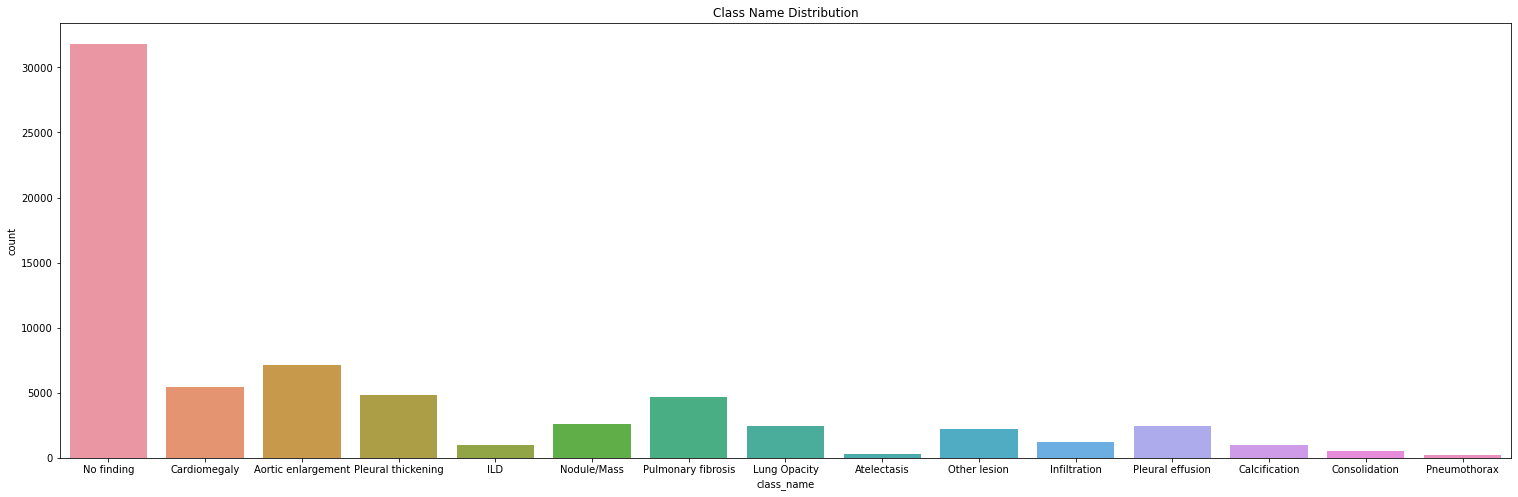

In [17]:
plt.figure(figsize=(26, 8))
sns.countplot(x="class_name", data=train_df)
plt.title("Class Name Distribution")
plt.show()

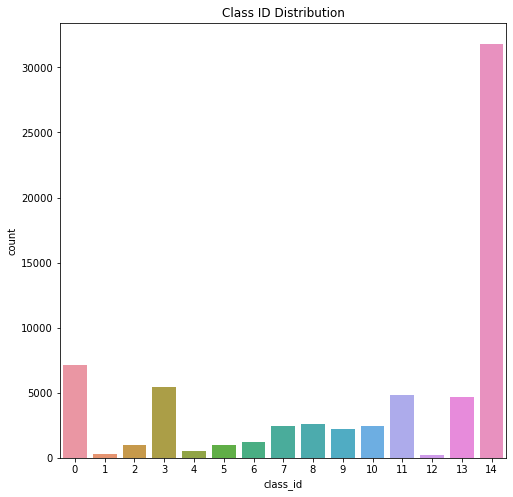

In [18]:
plt.figure(figsize=(8, 8))
sns.countplot(x="class_id", data=train_df)
plt.title("Class ID Distribution")
plt.show()

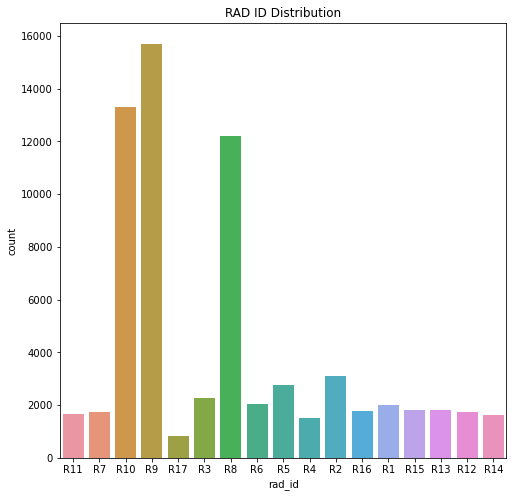

In [19]:
plt.figure(figsize=(8, 8))
sns.countplot(x="rad_id", data=train_df)
plt.title("RAD ID Distribution")
plt.show()

<Figure size 720x720 with 0 Axes>

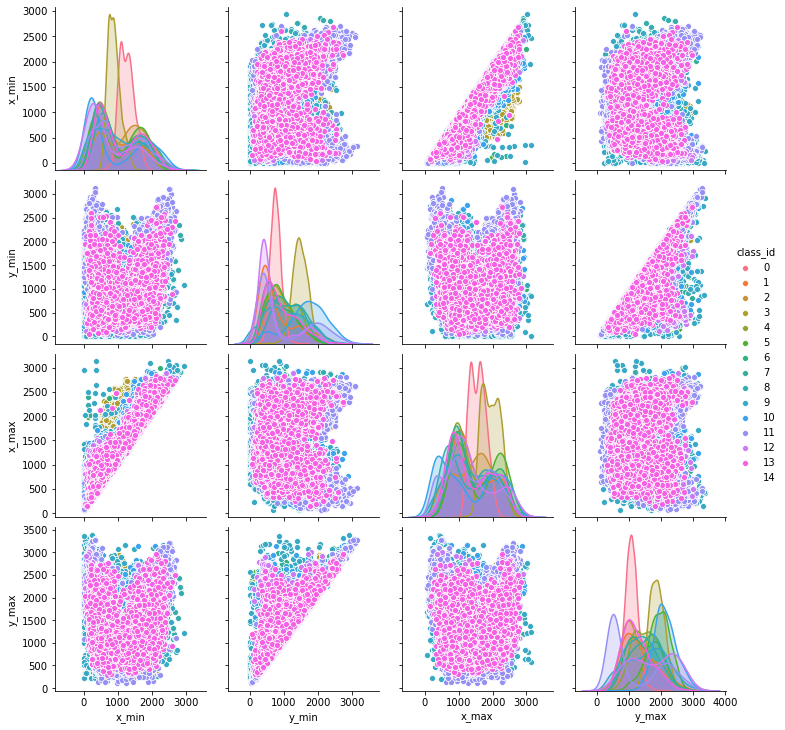

In [20]:
plt.figure(figsize=(10, 10))
sns.pairplot(train_df, hue='class_id')
plt.show()

In [21]:
print("Number of train images: ", len(train_files))
print("Number of test images: ", len(test_files))

Number of train images:  15000
Number of test images:  3000


We have 15000 images for Train and 3000 images for Test. But, the length of train_df is 67914. So, are there any duplicacy or something? Let's have a sanity check on unique image_ids of train_df.

In [22]:
print("Unique images in train_df: ", train_df.image_id.nunique())

Unique images in train_df:  15000


It's confirmed that we have one or more than one ground truths in our train dataset. Now, we got a lot to explore, such as:

Whether the boxes are overlapped on a single image? What about different classes? Are they over-lapped too for different classes? In a single image, what's the maximum number of class (or taregt present)? etc.

We will continue to explore these aspects and try to come with some insights, but let's worry about DICOM at the first place. Let's read out some image file names from both the train and test folders.

In [23]:
for _ in range(3):
    print(train_files[random.randint(0, len(train_files))])

4e591732049659e63f5ede8d6669bb5d.png
9369d8c9b16544b4f5c2d953f972a87c.png
1e685beca49d62411bb69bc4ddf7ad11.png


**7.2 Exploration of DICOM**

DICOM files can be exchanged between two entities that are capable of receiving image and patient data in DICOM format.

The different devices come with DICOM Conformance Statements which state which DICOM classes they support. 
The standard includes a file format definition and a network communications protocol that uses TCP/IP to communicate between systems.

Let's read one sample and grind it.

In [24]:
#sample_fn = train_df.image_id.to_list()[random.randint(0, len(train_df))]
#sample = pdc.read_file(os.path.join(train_dir, sample_fn + ".dicom"))
#sample

So, for a single patient(yes, there is one-one mapping in patients and image_ids, so there is no duplicates or more than one images per patient, as confirmed by the organizers in the discussion forum), we have following entities:

Patient's Sex Samples per Pixel Photometric Interpretation Rows Columns Pixel Spacing Bits Allocated Bits Stored High Bit Pixel Representation Window Center Window Width Rescale Intercept Rescale Slope Lossy Image Compression Pixel Data

In [25]:
def read_dicom_df(fn):
    _ = pdc.read_file(os.path.join(train_dir, fn))
    pass

In [26]:
def plot_pixel_array(data, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=plt.cm.bone)
    plt.show()

In [27]:
# ref kernel: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut=True, fix_monochrome=True):
    dcm_data = pdc.read_file(path)
    
    def show_dcm_info(data):
        print("Gender :", data.PatientSex)
        if 'PixelData' in data:
            rows = int(data.Rows)
            cols = int(data.Columns)
            print("Image size : {rows:d} x {cols:d}, {size:d} bytes".format(
                rows=rows, cols=cols, size=len(data.PixelData)))
            if 'PixelSpacing' in data:
                print("Pixel spacing :", data.PixelSpacing)
    
    show_dcm_info(dcm_data)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dcm_data.pixel_array, dcm_data)
    else:
        data = dcm_data.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dcm_data.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

7.2.1 Visualizing Train and Test Images

In [28]:
#print("Examining train images...")
#for _ in range(5):
 #   fn = train_files[np.random.randint(0, len(train_files))]
 #   file_path = os.path.join(train_dir, fn)
  # plot_pixel_array(data)

In [29]:
#print("Examining test images...")
#for _ in range(5):
 #   fn = test_files[np.random.randint(0, len(test_files))]
  #  file_path = os.path.join(test_dir, fn)
   # data = read_xray(file_path)
    #plot_pixel_array(data)

7.2.2 Checking the Localizations

In [30]:
# for _ in range(10):
#     idx = np.random.randint(0, len(train_files))
#     img_id = train_df.loc[idx, 'image_id']
#     img = read_xray(os.path.join(train_dir, img_id+".dicom"))
#     plt.figure(figsize=(8, 14))
#     plt.imshow(img, cmap='gray')
#     plt.title(train_df.loc[idx, 'class_name'])
    
#     if train_df.loc[idx, 'class_name'] != 'No finding':
#         bbox = [train_df.loc[idx, 'x_min'],
#                 train_df.loc[idx, 'y_min'],
#                 train_df.loc[idx, 'x_max'],
#                 train_df.loc[idx, 'y_max']]
        
#         patch = ptc.Rectangle((bbox[0], bbox[1]),
#                               bbox[2]-bbox[0],
#                               bbox[3]-bbox[1],
#                               ec='r', fc='none', lw=2.)
#         ax = plt.gca()
#         ax.add_patch(patch)

In [31]:
def save_yaml(filepath: str, content: Any, width: int = 120):
    with open(filepath, "w") as f:
        yaml.dump(content, f, width=width)

Flags Class summarizes all the configuratoin available during the training. 

The users can change various hyperparameters to experiment improving your models

In [32]:
@dataclass
class Flags:
    # General
    debug: bool = True
    outdir: str = "results/det"
    device: str = "cuda:0"

    # Data config
    imgdir_name: str = "vinbigdata-chest-xray-resized-png-256x256"
    # split_mode: str = "all_train"  # all_train or valid20
    seed: int = 111
    target_fold: int = 0  # 0~4
    label_smoothing: float = 0.0
    # Model config
    model_name: str = "resnet18"
    model_mode: str = "normal"  # normal, cnn_fixed supported
    # Training config
    epoch: int = 20
    batchsize: int = 8
    valid_batchsize: int = 16
    num_workers: int = 4
    snapshot_freq: int = 5
    ema_decay: float = 0.999  # negative value is to inactivate ema.
    scheduler_type: str = ""
    scheduler_kwargs: Dict[str, Any] = field(default_factory=lambda: {})
    scheduler_trigger: List[Union[int, str]] = field(default_factory=lambda: [1, "iteration"])
    aug_kwargs: Dict[str, Dict[str, Any]] = field(default_factory=lambda: {})
    mixup_prob: float = -1.0  # Apply mixup augmentation when positive value is set.

    def update(self, param_dict: Dict) -> "Flags":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self

In [33]:
flags_dict = {
    "debug": False,  # Change to True for fast debug run!
    "outdir": "results/tmp_debug",
    # Data
    "imgdir_name": "vinbigdata-chest-xray-resized-png-256x256",
    # Model
    "model_name": "resnet18",
    # Training
    "num_workers": 4,
    "epoch": 15,
    "batchsize": 8,
    "scheduler_type": "CosineAnnealingWarmRestarts",
    "scheduler_kwargs": {"T_0": 28125},  # 15000 * 15 epoch // (batchsize=8)
    "scheduler_trigger": [1, "iteration"],
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
        "CoarseDropout": {"max_holes": 8, "max_height": 25, "max_width": 25, "p": 0.5},
        "Blur": {"blur_limit": [3, 7], "p": 0.5},
        "Downscale": {"scale_min": 0.25, "scale_max": 0.9, "p": 0.3},
        "RandomGamma": {"gamma_limit": [80, 120], "p": 0.6},
    }
}

In [34]:
# args = parse()
print("torch", torch.__version__)
flags = Flags().update(flags_dict)
print("flags", flags)
debug = flags.debug
outdir = Path(flags.outdir)
os.makedirs(str(outdir), exist_ok=True)
flags_dict = dataclasses.asdict(flags)
save_yaml(str(outdir / "flags.yaml"), flags_dict)

# # --- Read data ---
# inputdir = Path("..input")
# datadir = inputdir / "vinbigdata-chest-xray-abnormalities-detection"
imgdir = "../input/vinbigdata-chest-xray-abnormalities-detection/" + flags.imgdir_name

# Read in the data CSV files
train = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
# sample_submission = pd.read_csv(datadir / 'sample_submission.csv')

torch 1.7.0
flags Flags(debug=False, outdir='results/tmp_debug', device='cuda:0', imgdir_name='vinbigdata-chest-xray-resized-png-256x256', seed=111, target_fold=0, label_smoothing=0.0, model_name='resnet18', model_mode='normal', epoch=15, batchsize=8, valid_batchsize=16, num_workers=4, snapshot_freq=5, ema_decay=0.999, scheduler_type='CosineAnnealingWarmRestarts', scheduler_kwargs={'T_0': 28125}, scheduler_trigger=[1, 'iteration'], aug_kwargs={'HorizontalFlip': {'p': 0.5}, 'ShiftScaleRotate': {'scale_limit': 0.15, 'rotate_limit': 10, 'p': 0.5}, 'RandomBrightnessContrast': {'p': 0.5}, 'CoarseDropout': {'max_holes': 8, 'max_height': 25, 'max_width': 25, 'p': 0.5}, 'Blur': {'blur_limit': [3, 7], 'p': 0.5}, 'Downscale': {'scale_min': 0.25, 'scale_max': 0.9, 'p': 0.3}, 'RandomGamma': {'gamma_limit': [80, 120], 'p': 0.6}}, mixup_prob=-1.0)


7.2 Exploration of Normal and Abnromal Classes

We need to check how many normal class exist in the training data.
It is classified as "class_name = No finding" and "class_id = 14".

However you need to be careful that 3 radiologists annotated for each image, 
so you can find 3 annotations as you can see below.

In [35]:
train.query("image_id == '50a418190bc3fb1ef1633bf9678929b3'")

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
45863,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN
57424,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN


Is there an image that the 3 radiologists' opinions differ?

Let's check number of "No finding" annotations for each image.
If the opinions are in complete agreement the number of "No finding" annotations, then it should be 
**0 -> Abnormal(all radiologists does not think this is normal)" or 
"1 -> Normal(all radiologists think this is normal)"**.

In [36]:
is_normal_df = train.groupby("image_id")["class_id"].agg(lambda s: (s == 14).sum()).reset_index().rename({"class_id": "num_normal_annotations"}, axis=1)
is_normal_df.head()

,image_id,num_normal_annotations
0,000434271f63a053c4128a0ba6352c7f,3
1,00053190460d56c53cc3e57321387478,3
2,0005e8e3701dfb1dd93d53e2ff537b6e,0
3,0006e0a85696f6bb578e84fafa9a5607,3
4,0007d316f756b3fa0baea2ff514ce945,0


It could confirm that **always 3 radiologists opinions match** for normal - abnormal diagnosis.

Noticed that it does not apply for the other classes. 
i.e., 3 radiologists opinions sometimes do not match for the other class of thoracic abnormalities.

Text(0.5, 1.0, "The number of 'No finding' annotations in each image")

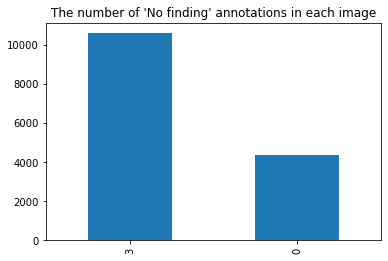

In [37]:
num_normal_anno_counts = is_normal_df["num_normal_annotations"].value_counts()
num_normal_anno_counts.plot(kind="bar")
plt.title("The number of 'No finding' annotations in each image")

In [38]:
num_normal_anno_counts_df = num_normal_anno_counts.reset_index()
num_normal_anno_counts_df["name"] = num_normal_anno_counts_df["index"].map({0: "Abnormal", 3: "Normal"})
num_normal_anno_counts_df

,index,num_normal_annotations,name
0,3,10606,Normal
1,0,4394,Abnormal


In [39]:
normal_count = num_normal_anno_counts_df.iloc[0]['num_normal_annotations']
abnormal_count = num_normal_anno_counts_df.iloc[1]['num_normal_annotations']

print("% of Normal X-Ray Images = ", round((normal_count/(normal_count+abnormal_count))*100),3)
print("% of AbNormal X-Ray Images = ", round((abnormal_count/(normal_count+abnormal_count))*100),3)

% of Normal X-Ray Images =  71.0 3
% of AbNormal X-Ray Images =  29.0 3


So around 70% of the data is actually "Normal" X-ray images.

But about 30% of the images need thoracic abnormality location detection.

**8. Image Visualizaion and Augmentation with Albumentations**

When you train CNN models, Image Augmentation is important to avoid model to overfit.
The below examples to use Albumentations to run image augmentation very easily
At first, I will define pytorch Dataset class for this competition, which can be also used later in the training.

In [40]:
def get_vinbigdata_dicts(
    imgdir: Path,
    train_df: pd.DataFrame,
    train_data_type: str = "original",
    use_cache: bool = True,
    debug: bool = True,
    target_indices: Optional[np.ndarray] = None,
):
    debug_str = f"_debug{int(debug)}"
    train_data_type_str = f"_{train_data_type}"
    cache_path = Path(".") / f"dataset_dicts_cache{train_data_type_str}{debug_str}.pkl"
    resized_height = 0
    resized_width = 0
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        train_meta = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train_meta.csv")
        if debug:
            train_meta = train_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = train_meta.loc[0, "image_id"]
        image_path = str("../input/vinbigdata-chest-xray-abnormalities-detection/train/f{0}.png").format(image_id)
        image = cv2.imread(image_path)
        if image is None:
            pass
        else:
            resized_height, resized_width, ch = image.shape
            print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, train_meta_row in tqdm(train_meta.iterrows(), total=len(train_meta)):
            record = {}

            image_id, height, width = train_meta_row.values
            filename = str("../input/vinbigdata-chest-xray-abnormalities-detection/train/f{0}.png").format(image_id)
            record["file_name"] = filename
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            objs = []
            for index2, row in train_df.query("image_id == @image_id").iterrows():
                # print(row)
                # print(row["class_name"])
                # class_name = row["class_name"]
                class_id = row["class_id"]
                if class_id == 14:
                    # It is "No finding"
                    # This annotator does not find anything, skip.
                    pass
                else:
                    # bbox_original = [int(row["x_min"]), int(row["y_min"]), int(row["x_max"]), int(row["y_max"])]
                    h_ratio = resized_height / height
                    w_ratio = resized_width / width
                    bbox_resized = [
                        int(row["x_min"]) * w_ratio,
                        int(row["y_min"]) * h_ratio,
                        int(row["x_max"]) * w_ratio,
                        int(row["y_max"]) * h_ratio,
                    ]
                    obj = {
                        "bbox": bbox_resized,
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": class_id,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]
    return dataset_dicts

def get_vinbigdata_dicts_test(
    imgdir: Path, test_meta: pd.DataFrame, use_cache: bool = True, debug: bool = True,
):
    debug_str = f"_debug{int(debug)}"
    cache_path = Path(".") / f"dataset_dicts_cache_test{debug_str}.pkl"
    if not use_cache or not cache_path.exists():
        print("Creating data...")
        # test_meta = pd.read_csv(imgdir / "test_meta.csv")
        if debug:
            test_meta = test_meta.iloc[:500]  # For debug....

        # Load 1 image to get image size.
        image_id = test_meta.loc[0, "image_id"]
        image_path = str(imgdir / "test" / f"{image_id}.png")
        image = cv2.imread(image_path)
        resized_height, resized_width, ch = image.shape
        print(f"image shape: {image.shape}")

        dataset_dicts = []
        for index, test_meta_row in tqdm(test_meta.iterrows(), total=len(test_meta)):
            record = {}

            image_id, height, width = test_meta_row.values
            filename = str("../input/vinbigdata-chest-xray-abnormalities-detection/train/f{0}.png").format(image_id)
            record["file_name"] = filename
            # record["image_id"] = index
            record["image_id"] = image_id
            record["height"] = resized_height
            record["width"] = resized_width
            # objs = []
            # record["annotations"] = objs
            dataset_dicts.append(record)
        with open(cache_path, mode="wb") as f:
            pickle.dump(dataset_dicts, f)

    print(f"Load from cache {cache_path}")
    with open(cache_path, mode="rb") as f:
        dataset_dicts = pickle.load(f)
    return dataset_dicts


In [41]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy

class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


Here mixup augmentation in the dataset. It makes interpolation of 2 images, with the label is also modified according to the mix ratio. 
mixup augmentation is especially useful when the number of data is limited.
Because it can make combination of any 2 images, instead of just using 1 image.

I also added label smoothing feature. 
Sometimes it is difficult to learn label is 0, 1. 
Label smoothing changes its label 0 -> 0.01 & 1 -> 0.99. 
By smoothing the label the loss surface becomes more "soft", and sometimes model can learn well.

In [42]:
class VinbigdataTwoClassDataset(DatasetMixin):
    def __init__(self, dataset_dicts, image_transform=None, transform=None, train: bool = True,
                 mixup_prob: float = -1.0, label_smoothing: float = 0.0):
        super(VinbigdataTwoClassDataset, self).__init__(transform=transform)
        self.dataset_dicts = dataset_dicts
        self.image_transform = image_transform
        self.train = train
        self.mixup_prob = mixup_prob
        self.label_smoothing = label_smoothing

    def _get_single_example(self, i):
        d = self.dataset_dicts[i]
        filename = d["file_name"]

        img = cv2.imread(filename)
        if self.image_transform:
            img = self.image_transform(img)
        img = torch.tensor(np.transpose(img, (2, 0, 1)).astype(np.float32))

        if self.train:
            label = int(len(d["annotations"]) > 0)  # 0 normal, 1 abnormal
            if self.label_smoothing > 0:
                if label == 0:
                    return numpy.asarray(img), float(label) + self.label_smoothing
                else:
                    return numpy.asarray(img), float(label) - self.label_smoothing
            else:
                return numpy.asarray(img), float(label)
        else:
            # Only return img
            return numpy.asarray(img), None

    def get_example(self, i):
        img, label = self._get_single_example(i)
        if self.mixup_prob > 0. and np.random.uniform() < self.mixup_prob:
            j = np.random.randint(0, len(self.dataset_dicts))
            p = np.random.uniform()
            img2, label2 = self._get_single_example(j)
            img = img * p + img2 * (1 - p)
            if self.train:
                label = label * p + label2 * (1 - p)

        if self.train:
            label_logit = torch.tensor([1 - label, label], dtype=torch.float32)
            return numpy.asarray(img), label_logit
        else:
            # Only return img
            return numpy.asarray(img)

    def __len__(self):
        return len(self.dataset_dicts)

Now creating the dataset is just easy as following:

In [43]:
dataset_dicts = get_vinbigdata_dicts(imgdir, train, debug=debug)
dataset = VinbigdataTwoClassDataset(dataset_dicts)

Load from cache dataset_dicts_cache_original_debug0.pkl


You can access each image and its label (0=Normal, 1=Abnormal) by just access `dataset` with index.

In [44]:
# index = 0
# img, label = dataset[index]
# plt.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
# plt.title(f"{index}-th image: label {label}")

To run augmentation on this image, I will define `Transform` class which is applied each time the data is accessed.

In [45]:
class Transform:
    def __init__(
        self, hflip_prob: float = 0.5, ssr_prob: float = 0.5, random_bc_prob: float = 0.5
    ):
        self.transform = A.Compose(
            [
                A.HorizontalFlip(p=hflip_prob),
                A.ShiftScaleRotate(
                    shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=ssr_prob
                ),
                A.RandomBrightnessContrast(p=random_bc_prob),
            ]
        )

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return numpy.asarray(image)


To use augmentation, you can just define dataset with the `Transform` function.

In [46]:
aug_dataset = VinbigdataTwoClassDataset(dataset_dicts, image_transform=Transform())

Let's visualize, looks good. <br/>
You can see each image looks different (rotated, brightness is different etc...) even if it is generated from the same image :)

In [47]:
# index = 0

# n_images = 4

# fig, axes = plt.subplots(1, n_images, figsize=(16, 5))
# for i in range(n_images):
#     # Each time the data is accessed, the result is different due to random augmentation!
#     img, label = aug_dataset[index]
#     ax = axes[i]
#     ax.imshow(img.cpu().numpy().transpose((1, 2, 0)) / 255.)
#     ax.set_title(f"{index}-th image: label {label}")
# plt.show()

In [48]:
class Transform:
    def __init__(self, aug_kwargs: Dict):
        self.transform = A.Compose(
            [getattr(A, name)(**kwargs) for name, kwargs in aug_kwargs.items()]
        )

    def __call__(self, image):
        image = self.transform(image=image)["image"]
        return numpy.asarray(image)

**9. Model Building(CNN Models)**

I will use `timm` this time. You can just re-use latest research results without hustle.

In [49]:
class CNNFixedPredictor(nn.Module):
    def __init__(self, cnn: nn.Module, num_classes: int = 2):
        super(CNNFixedPredictor, self).__init__()
        self.cnn = cnn
        self.lin = Linear(cnn.num_features, num_classes)
        print("cnn.num_features", cnn.num_features)

        # We do not learn CNN parameters.
        # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
        for param in self.cnn.parameters():
            param.requires_grad = False

    def forward(self, x):
        feat = self.cnn(x)
        return self.lin(feat)


**11. Model Validation**

In [50]:
def build_predictor(model_name: str, model_mode: str = "normal"):
    if model_mode == "normal":
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=True, num_classes=2, in_chans=3)
    elif model_mode == "cnn_fixed":
        # normal configuration. train all parameters.
        # https://rwightman.github.io/pytorch-image-models/feature_extraction/
        timm_model = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        return CNNFixedPredictor(timm_model, num_classes=2)
    else:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_mode}")


In [51]:
def accuracy(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape[:-1] == t.shape, f"y {y.shape}, t {t.shape} is inconsistent."
    pred_label = torch.max(y.detach(), dim=-1)[1]
    count = t.nelement()
    correct = (pred_label == t).sum().float()
    acc = correct / count
    return acc

def accuracy_with_logits(y: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Computes multi-class classification accuracy"""
    assert y.shape == t.shape
    gt_label = torch.max(t.detach(), dim=-1)[1]
    return accuracy(y, gt_label)

In [52]:
def cross_entropy_with_logits(input, target, dim=-1):
    loss = torch.sum(- target * F.log_softmax(input, dim), dim)
    return loss.mean()


In [53]:
class Classifier(nn.Module):
    """two class classfication"""

    def __init__(self, predictor, lossfun=cross_entropy_with_logits):
        super().__init__()
        self.predictor = predictor
        self.lossfun = lossfun
        self.prefix = ""

    def forward(self, image, targets):
        outputs = self.predictor(image)
        loss = self.lossfun(outputs, targets)
        metrics = {
            f"{self.prefix}loss": loss.item(),
            f"{self.prefix}acc": accuracy_with_logits(outputs, targets).item()
        }
        ppe.reporting.report(metrics, self)
        return loss, metrics

    def predict(self, data_loader):
        pred = self.predict_proba(data_loader)
        label = torch.argmax(pred, dim=1)
        return label

    def predict_proba(self, data_loader):
        device: torch.device = next(self.parameters()).device
        y_list = []
        self.eval()
        with torch.no_grad():
            for batch in data_loader:
                if isinstance(batch, (tuple, list)):
                    # Assumes first argument is "image"
                    batch = batch[0].to(device)
                else:
                    batch = batch.to(device)
                y = self.predictor(batch)
                y = torch.softmax(y, dim=-1)
                y_list.append(y)
        pred = torch.cat(y_list)
        return pred


What kind of models are supported in the `timm` library?

In [54]:
supported_models = timm.list_models()
print(f"{len(supported_models)} models are supported in timm.")
print(supported_models)

434 models are supported in timm.
['adv_inception_v3', 'cspdarknet53', 'cspdarknet53_iabn', 'cspresnet50', 'cspresnet50d', 'cspresnet50w', 'cspresnext50', 'cspresnext50_iabn', 'darknet53', 'densenet121', 'densenet121d', 'densenet161', 'densenet169', 'densenet201', 'densenet264', 'densenet264d_iabn', 'densenetblur121d', 'dla34', 'dla46_c', 'dla46x_c', 'dla60', 'dla60_res2net', 'dla60_res2next', 'dla60x', 'dla60x_c', 'dla102', 'dla102x', 'dla102x2', 'dla169', 'dm_nfnet_f0', 'dm_nfnet_f1', 'dm_nfnet_f2', 'dm_nfnet_f3', 'dm_nfnet_f4', 'dm_nfnet_f5', 'dm_nfnet_f6', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'eca_vovnet39b', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'ecaresnext26t_32x4d', 'ecaresnext50t_32x4d', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b2a', 'efficientnet_b3', '

434 models are supported including **resnet** related models, **efficientnet**
You may wonder which model should be used?
I will go with `resnet18` as a baseline at first, and try using more deeper/latest models in the experiment.

**10. Model Training**

In [55]:
"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
class EMA(object):
    """Exponential moving average of model parameters.

    Ref
     - https://github.com/tensorflow/addons/blob/v0.10.0/tensorflow_addons/optimizers/moving_average.py#L26-L103
     - https://anmoljoshi.com/Pytorch-Dicussions/

    Args:
        model (nn.Module): Model with parameters whose EMA will be kept.
        decay (float): Decay rate for exponential moving average.
        strict (bool): Apply strict check for `assign` & `resume`.
        use_dynamic_decay (bool): Dynamically change decay rate. If `True`, small decay rate is
            used at the beginning of training to move moving average faster.
    """  # NOQA

    def __init__(
        self,
        model: nn.Module,
        decay: float,
        strict: bool = True,
        use_dynamic_decay: bool = True,
    ):
        self.decay = decay
        self.model = model
        self.strict = strict
        self.use_dynamic_decay = use_dynamic_decay
        self.logger = getLogger(__name__)
        self.n_step = 0

        self.shadow = {}
        self.original = {}

        # Flag to manage which parameter is assigned.
        # When `False`, original model's parameter is used.
        # When `True` (`assign` method is called), `shadow` parameter (ema param) is used.
        self._assigned = False

        # Register model parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def step(self):
        self.n_step += 1
        if self.use_dynamic_decay:
            _n_step = float(self.n_step)
            decay = min(self.decay, (1.0 + _n_step) / (10.0 + _n_step))
        else:
            decay = self.decay

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                new_average = (1.0 - decay) * param.data + decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    # alias
    __call__ = step

    def assign(self):
        """Assign exponential moving average of parameter values to the respective parameters."""
        if self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `assign` is called again before `resume`.")
            else:
                self.logger.warning(
                    "`assign` is called again before `resume`."
                    "shadow parameter is already assigned, skip."
                )
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                self.original[name] = param.data.clone()
                param.data = self.shadow[name]
        self._assigned = True

    def resume(self):
        """Restore original parameters to a model.

        That is, put back the values that were in each parameter at the last call to `assign`.
        """
        if not self._assigned:
            if self.strict:
                raise ValueError("[ERROR] `resume` is called before `assign`.")
            else:
                self.logger.warning("`resume` is called before `assign`, skip.")
                return

        for name, param in self.model.named_parameters():
            if param.requires_grad:
                assert name in self.shadow
                param.data = self.original[name]
        self._assigned = False


In [56]:
"""
From https://github.com/pfnet-research/kaggle-lyft-motion-prediction-4th-place-solution
"""
class LRScheduler(Extension):
    """A thin wrapper to resume the lr_scheduler"""

    trigger = 1, 'iteration'
    priority = PRIORITY_READER
    name = None

    def __init__(self, optimizer: optim.Optimizer, scheduler_type: str, scheduler_kwargs: Mapping[str, Any]) -> None:
        super().__init__()
        self.scheduler = getattr(optim.lr_scheduler, scheduler_type)(optimizer, **scheduler_kwargs)

    def __call__(self, manager: ExtensionsManager) -> None:
        self.scheduler.step()

    def state_dict(self) -> None:
        return self.scheduler.state_dict()

    def load_state_dict(self, to_load) -> None:
        self.scheduler.load_state_dict(to_load)


In [57]:

def create_trainer(model, optimizer, device) -> Engine:
    model.to(device)

    def update_fn(engine, batch):
        model.train()
        optimizer.zero_grad()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        loss.backward()
        optimizer.step()
        return metrics
    trainer = Engine(update_fn)
    return trainer


**11. Model Testing and Validation**

When we have few data, running stable evaluation is very important. 
We can use cross validation to reduce validation error standard deviation.

I will use **[`StratifiedKFold`]** to keep the balance between normal/abnormal ratio same for the train & validation dataset.

According to [this discussion](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/208837#1139712), using multi label stratified kfold https://github.com/trent-b/iterative-stratification may be more stable.

In [58]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=flags.seed)
# skf.get_n_splits(None, None)
y = np.array([int(len(d["annotations"]) > 0) for d in dataset_dicts])
split_inds = list(skf.split(dataset_dicts, y))
train_inds, valid_inds = split_inds[flags.target_fold]  # 0th fold
train_dataset = VinbigdataTwoClassDataset(
    [dataset_dicts[i] for i in train_inds],
    image_transform=Transform(flags.aug_kwargs),
    mixup_prob=flags.mixup_prob,
    label_smoothing=flags.label_smoothing,
)
valid_dataset = VinbigdataTwoClassDataset([dataset_dicts[i] for i in valid_inds])


**10. Model Training**

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=flags.batchsize,
    num_workers=flags.num_workers,
    shuffle=True,
    pin_memory=True,
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)

device = torch.device("cpu")

predictor = build_predictor(model_name=flags.model_name, model_mode=flags.model_mode)
classifier = Classifier(predictor)
model = classifier
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=1e-3)

# Train setup
trainer = create_trainer(model, optimizer, device)

ema = EMA(predictor, decay=flags.ema_decay)

def eval_func(*batch):
    loss, metrics = model(*[elem.to(device) for elem in batch])
    # HACKING: report ema value with prefix.
    if flags.ema_decay > 0:
        classifier.prefix = "ema_"
        ema.assign()
        loss, metrics = model(*[elem.to(device) for elem in batch])
        ema.resume()
        classifier.prefix = ""

valid_evaluator = E.Evaluator(
    valid_loader, model, progress_bar=False, eval_func=eval_func, device=device
)

# log_trigger = (10 if debug else 1000, "iteration")
log_trigger = (1, "epoch")
log_report = E.LogReport(trigger=log_trigger)
extensions = [
    log_report,
    E.ProgressBarNotebook(update_interval=10 if debug else 100),  # Show progress bar during training
    E.PrintReportNotebook(),  # Show "log" on jupyter notebook  
    # E.ProgressBar(update_interval=10 if debug else 100),  # Show progress bar during training
    # E.PrintReport(),  # Print "log" to terminal
    E.FailOnNonNumber(),  # Stop training when nan is detected.
]
epoch = flags.epoch
models = {"main": model}
optimizers = {"main": optimizer}
manager = IgniteExtensionsManager(
    trainer, models, optimizers, epoch, extensions=extensions, out_dir=str(outdir),
)
# Run evaluation for valid dataset in each epoch.
manager.extend(valid_evaluator)

# Save predictor.pt every epoch
manager.extend(
    E.snapshot_object(predictor, "predictor.pt"), trigger=(flags.snapshot_freq, "epoch")
)
# Check & Save best validation predictor.pt every epoch
# manager.extend(E.snapshot_object(predictor, "best_predictor.pt"),
#                trigger=MinValueTrigger("validation/module/nll",
#                trigger=(flags.snapshot_freq, "iteration")))

# --- lr scheduler ---
if flags.scheduler_type != "":
    scheduler_type = flags.scheduler_type
    print(f"using {scheduler_type} scheduler with kwargs {flags.scheduler_kwargs}")
    manager.extend(
        LRScheduler(optimizer, scheduler_type, flags.scheduler_kwargs),
        trigger=flags.scheduler_trigger,
    )

manager.extend(E.observe_lr(optimizer=optimizer), trigger=log_trigger)

if flags.ema_decay > 0:
    # Exponential moving average
    manager.extend(lambda manager: ema(), trigger=(1, "iteration"))

    def save_ema_model(manager):
        ema.assign()
        torch.save(predictor.state_dict(), outdir / "predictor_ema.pt")
        ema.resume()

    manager.extend(save_ema_model, trigger=(flags.snapshot_freq, "epoch"))

_ = trainer.run(train_loader, max_epochs=epoch)

using CosineAnnealingWarmRestarts scheduler with kwargs {'T_0': 28125}


HTML(value='')

**13. Discussion**

**Extensions** - Each role:
 - **`ProgressBar` (`ProgressBarNotebook`)**: Shows training progress in formatted style.
 - **`LogReport`**: Logging metrics reported by `ppe.reporter.report` (see `LyftMultiRegressor` for reporting point) method and save to **log** file. It automatically collects reported value in each iteration and saves the "mean" of reported value for regular frequency (for example every 1 epoch).
 - **`PrintReport` (`PrintReportNotebook`)**: Prints the value which `LogReport` collected in formatted style.
 - **`Evaluator`**: Evaluate on validation dataset.
 - **`snapshot_object`**: Saves the object. Here the `model` is saved in regular interval `flags.snapshot_freq`. Even you quit training using Ctrl+C without finishing all the epoch, the intermediate trained model is saved and you can use it for inference.
 - **`LRScheduler`**: You can insert learning rate scheduling with this extension, together with the regular interval call specified by `trigger`. Here cosine annealing is applied (configured by Flags) by calling `scheduler.step()` every iteration.
 - **`observe_lr`**: `LogReport` will check optimizer's learning rate using this extension. So you can follow how the learning rate changed through the training

**11. Model Testing and Validation**

In [ ]:
torch.save(predictor.state_dict(), outdir / "predictor_last.pt")
df = log_report.to_dataframe()
df.to_csv(outdir / "log.csv", index=False)
df

**12. Results**

We can submit **14 prob 1 1 0 0** where the `prob` is the normal probability in the discussion [[Scoring bug] Improve your LB score by 0.053, just adding "14 1 0 0 1 1"](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971)!

Propose new post processing (similar to [this](https://www.kaggle.com/c/vinbigdata-chest-xray-abnormalities-detection/discussion/211971#1157809) by @pestipeti):

Here `p` is the **normal probability**.

1. `p < low_threshold`                   -> Do nothing, Keep det prediction.
2. `low_threshold <= p < high_threshold` -> Just "Add" Normal prediction, **keep** detection prediction.
3. `high_threshold <= p`                 -> Replace with Normal prediction with normal score 1.0, **remove** all detection predictoin.

In [ ]:
# --- Prediction ---
print("Training done! Start prediction...")
# valid data
valid_pred = classifier.predict_proba(valid_loader).cpu().numpy()
valid_pred_df = pd.DataFrame({
    "image_id": [dataset_dicts[i]["image_id"] for i in valid_inds],
    "class0": valid_pred[:, 0],
    "class1": valid_pred[:, 1]
})
valid_pred_df.to_csv(outdir/"valid_pred.csv", index=False)

# test data
test_meta = pd.read_csv(inputdir / "vinbigdata-testmeta" / "test_meta.csv")
dataset_dicts_test = get_vinbigdata_dicts_test(imgdir, test_meta, debug=debug)
test_dataset = VinbigdataTwoClassDataset(dataset_dicts_test, train=False)
test_loader = DataLoader(
    test_dataset,
    batch_size=flags.valid_batchsize,
    num_workers=flags.num_workers,
    shuffle=False,
    pin_memory=True,
)
test_pred = classifier.predict_proba(test_loader).cpu().numpy()
test_pred_df = pd.DataFrame({
    "image_id": [d["image_id"] for d in dataset_dicts_test],
    "class0": test_pred[:, 0],
    "class1": test_pred[:, 1]
})
test_pred_df.to_csv(outdir/"test_pred.csv", index=False)

In [ ]:
# --- Test dataset prediction result ---
test_pred_df

In [ ]:
sns.distplot(valid_pred_df["class0"].values, color='green', label='valid pred')
sns.distplot(test_pred_df["class0"].values, color='orange', label='test pred')
plt.title("Prediction results histogram")
plt.xlim([0., 1.])
plt.legend()

In [ ]:
# pred_2class = pd.read_csv(inputdir/"vinbigdata-2class-prediction/2-cls test pred.csv")  # LB 0.230
# low_threshold = 0.0
# high_threshold = 0.95

pred_2class = pd.read_csv(inputdir/"vinbigdata2classpred/test_pred.csv")
low_threshold = 0.0
high_threshold = 0.976
pred_2class

In [ ]:
NORMAL = "14 1 0 0 1 1"

pred_det_df = pd.read_csv(inputdir/"public-kernel-vinbigdata-detectron2-prediction-v9/results/20210110_train_all_500k_512/submission.csv")  # You can load from another submission.csv here too.
n_normal_before = len(pred_det_df.query("PredictionString == @NORMAL"))
merged_df = pd.merge(pred_det_df, pred_2class, on="image_id", how="left")

# 1. p < low_threshold                   -> "Keep": Do nothing, Keep det prediction.
# 2. low_threshold <= p < high_threshold -> "Add": Just "Add" Normal prediction
# 3. high_threshold <= p                 -> "Replace": Replace with Normal prediction

if "target" in merged_df.columns:
    merged_df["class0"] = 1 - merged_df["target"]

c0, c1, c2 = 0, 0, 0
for i in range(len(merged_df)):
    p0 = merged_df.loc[i, "class0"]
    if p0 < low_threshold:
        # Keep, do nothing.
        c0 += 1
    elif low_threshold <= p0 and p0 < high_threshold:
        # Add, keep "det" preds and add normal pred.
        merged_df.loc[i, "PredictionString"] += f" 14 {p0} 0 0 1 1"
        c1 += 1
    else:
        # Replace, remove all "det" preds.
        merged_df.loc[i, "PredictionString"] = NORMAL
        c2 += 1

n_normal_after = len(merged_df.query("PredictionString == @NORMAL"))
print(
    f"n_normal: {n_normal_before} -> {n_normal_after} with threshold {low_threshold} & {high_threshold}"
)
print(f"Keep {c0} Add {c1} Replace {c2}")
submission_filepath = str(outdir / "submission.csv")
submission_df = merged_df[["image_id", "PredictionString"]]
submission_df.to_csv(submission_filepath, index=False)
print(f"Saved to {submission_filepath}")

**13. Discussion**

(1) General
 - The baseline submission of score is 0.141
 - Augmentation is very important hyperparameter to improve model's performance, and 
   you want to experiment with various configurations.
   updated `Transform` function is written to **support all the augmentations implemented in 
   albumentations**.
   You can specify `aug_kwargs` from external configuration inside `Configuration`
 - **Exponential Moving Average of model weights** is calculated by `EMA` class during 
   training, together with showing its validation loss. We can usually obtrain more stable 
   models with EMA
 - Obtrained training history results really easily by just accessing `LogReport` class, which 
   is useful for managing a lot of experiments during kaggle competitions.
 - Now, the score improved by about **0.8, which is significant**!

(2) Details
 - Tried to change several `low_threshold` value and lower `low_threshold` achieved better 
   results. So it may be okay to set `low_threshold=0.0` which means **always add "No finding"    prediction with the predicted probability.**<br/>
 - Noticed that setting `high_threshold` value less than 1 is important, which means we have a 
   benefit to **remove abnormality predictions** for the images which is highly likely to be  
   normal.<br/>
 - Curently used [training kernel](https://www.kaggle.com/corochann/vinbigdata-detectron2-
   train) with abnormal image during training and model tend to produce more abnormal boxes. 
 - Better to include normal images for training to learn where there is **no** abnormality. 
   <br/>
 - Try to **include "No finding" class during detection training** (by adding virtual "No 
   finding" boxes, or by adding global classifier together with the detection).

That's all!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated 😁<br>Thanks!</h3>

14.Future Improvement

(1) Changing training configurations by just changing Flags (flags_dict) configuration.

Data
imgdir_name: You can use different preprocessed image introduced in [Multiple preprocessed datasets: 256/512/1024px, PNG and JPG, modified and original ratio]
Model
model_name: You can try various kinds of models timm library support, by just changing model_name.
Training
epoch, batch_size, scheduler_type etc: Try changing these hyperparamters, to see the difference!
Augmentation: Please modify Transform class to add your augmentation, it's easy to support more augmentations with albumentations library.
(2) Checking training loss/training accuracy: If it is almost same with validation loss/accuracy and it is not accurate enough, model's representation power may be not enough, or data augmentation is too strong. You can try more deeper models, decrease data augmentation or using more rich data (high-resolution image).

(3) Checking training loss/validation loss difference: If validation loss is very high compared to training loss, it is a sign of overfitting. Try using smaller models, increase data augmentation or apply regularization (dropout etc).

15. Reference

(1) Classifier Pipeline from the kernel of VinBigData 2-class classifier complete pipeline

(2) Trained Detection Model from the Kernel of VinBigData detectron2 train

(3) Training 2 Class Classifier from the Kernel of VinBigData 🌟2 Class Filter🌟

(4) VBD Chest X-ray Abnormalities Detection | EDA📊🔴

(5) Deep learning Pytorch in Computer Vision!

(6) Image Augmentation Library developed by famous Kagglers

(7) Pytorch-Image-Models with Petrained Weights

(8) Pytorch-Ignite Traning/Evaluation Abstraction Framework

(9) Pytorch Feature-Rich Functionality on Ignite

**16. Appendices**

- There are several other X-ray images in this research field.<br/>
- The paper of this competition dataset ["VinDr-CXR: An open dataset of chest X-rays with radiologist's annotations”.](https://arxiv.org/pdf/2012.15029.pdf)
summarizes the existing public datasets.
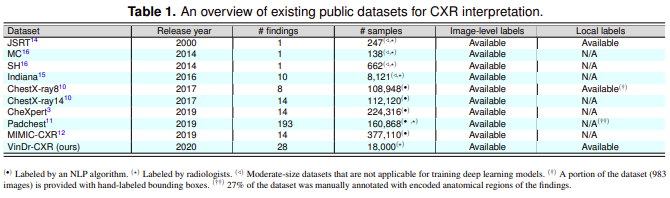